In [9]:
# NumPy library: allows for numerical computing
import numpy as np

# pandas library: used for data manipulation and analysis
import pandas as pd

# Quandl library: gives access to financial data
import quandl

# File with my quandl password
from conf import API_key

# matplotlib library: plots everything
import matplotlib.pyplot as plt
%matplotlib inline

_________

# Case II

__Best Asset Management (BAM) is a top-notch asset management company with operations worldwide. Your team got an internship opportunity and your first assignment is to help in the advisory process for a wealthy investor, Mr. Gonzalez.__

__
Mr. Gonzalez approached BAM for the development of an investment strategy more adjusted to his risk-return profile. Your internship supervisor, Mrs. Crusoe, wants you to conduct a comprehensive analysis on what might be a good asset allocation for this investor.__

In [37]:
# Import the excel file
data = pd.read_excel('./data_case.xlsx', index_col='Date')

# Order the columns in alphabetical order
data = data.reindex(sorted(data.columns), axis=1).drop(pd.Timestamp('2004-12-31'))

# Show the data
data.head()

,Commodities,Equity,Fixed income,Hedge Funds,Real Estate
Date,,,,,
2005-01-07,0.061548,0.014354,0.019900,0.028100,-0.007989
2005-01-14,0.037780,-0.003776,0.003577,-0.003210,-0.007760
2005-01-21,0.007729,-0.007996,0.001278,0.001171,0.009977
2005-01-28,-0.013148,0.006571,0.002871,0.001559,-0.018529
2005-02-04,-0.009279,0.033628,0.012232,0.017711,0.032902


__ For your assignment Mrs. Crusoe gave you weekly data on several asset classes that she considers appropriate for the investor and raised some questions that she believes will strengthen your analysis.__

__The risk-free rate is 3%.__

In [3]:
# Define the risk-free variable
r_f = 0.03

__________________

## Question 1

__ How did each of the asset classes performed throughout the whole sample period?__

In [4]:
# Create table, DataFrame, with historical indicators
sample_indicators = pd.DataFrame({'mean': data.mean()*52, 
                                  'std': data.std() * np.sqrt(52),
                                  'min': data.min(),
                                  'max': data.max()})

# Show table
sample_indicators

,max,mean,min,std
Commodities,0.143364,0.057365,-0.182563,0.214668
Equity,0.109478,0.093698,-0.179928,0.163640
Fixed income,0.059763,0.044597,-0.033792,0.070766
Hedge Funds,0.042825,0.023104,-0.051908,0.097868
Real Estate,0.174583,0.086825,-0.143572,0.208031


In [5]:
# Get covariance variance matrix
S = data.cov()*(365.25/7)

# Show it
S

,Commodities,Equity,Fixed income,Hedge Funds,Real Estate
Commodities,0.046241,0.014588,-0.000341,0.005410,0.012579
Equity,0.014588,0.026870,0.000484,0.008068,0.027308
Fixed income,-0.000341,0.000484,0.005025,0.004740,0.000799
Hedge Funds,0.005410,0.008068,0.004740,0.009611,0.006834
Real Estate,0.012579,0.027308,0.000799,0.006834,0.043426


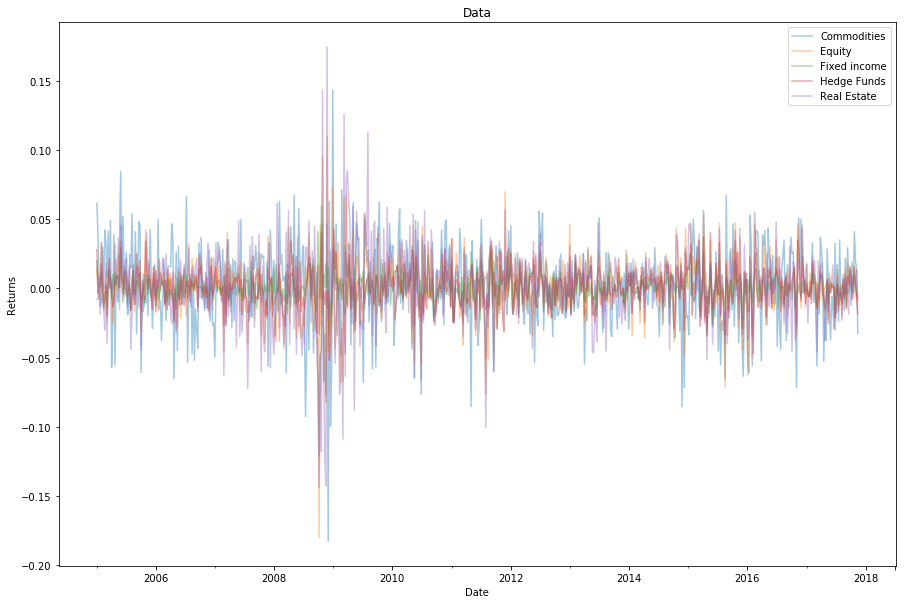

In [6]:
# Visualize the returns
data.plot(alpha=.4, figsize = (15,10), title='Data')

# Add label
plt.ylabel('Returns');

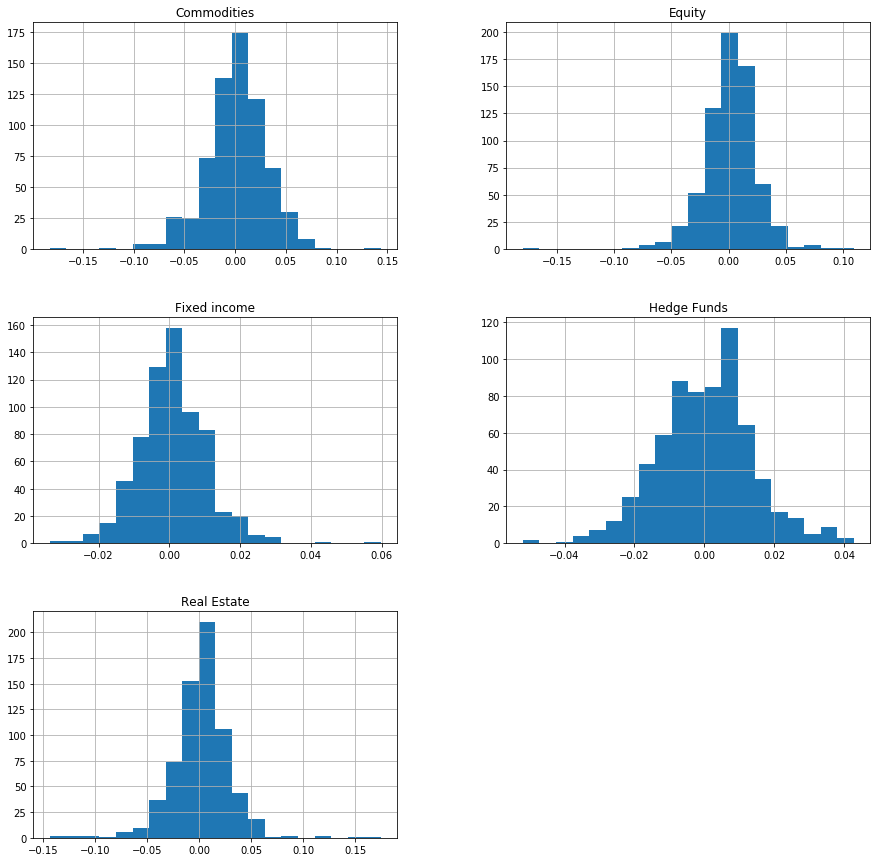

In [7]:
# Plot a histogram using 20 bins of the 5 asset classes
pd.DataFrame.hist(data, bins=20, figsize = (15,15));

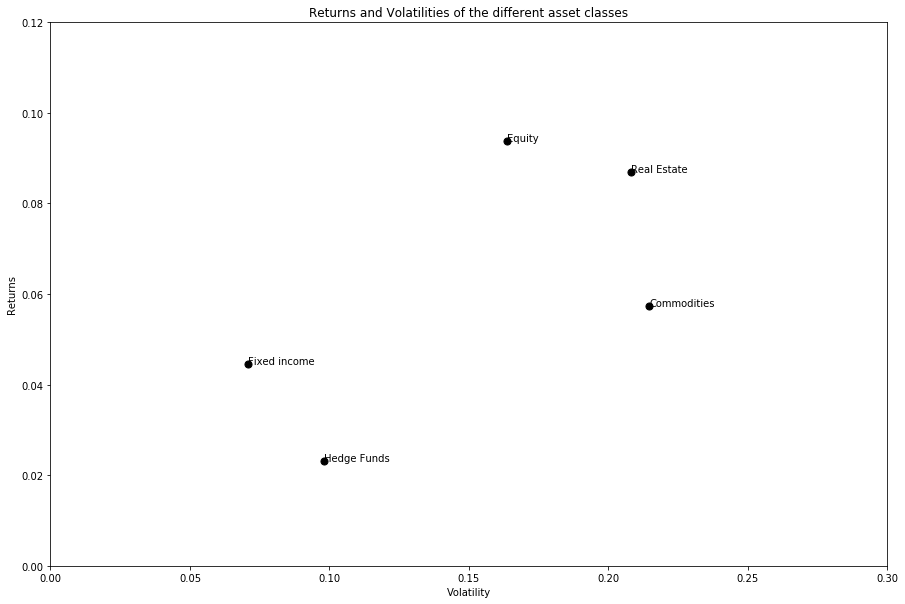

In [8]:
# Plot the Returns Volatility scatter
fig, ax = plt.subplots(figsize = (15,10))
ax.scatter(sample_indicators['std'], sample_indicators['mean'], marker="o",color='xkcd:black',s=50)

# Add the labels to each class
for i, txt in enumerate(data.columns.tolist()):
    ax.annotate(txt, (sample_indicators['std'].tolist()[i],sample_indicators['mean'].tolist()[i]))

# Define the limits for the graph
plt.ylim((0.00,0.12))
plt.xlim((0.00,0.3))

# Define the labels
plt.title('Returns and Volatilities of the different asset classes')
plt.xlabel('Volatility')
plt.ylabel('Returns');

___________

## Question 2

__ If there are no restrictions on short sales what would be the tangency portfolio? And if the investor is restricted on short sales? Compare the two portfolios.__

Firstly, with no restriction:

$$ weights_{T_{nr}} = \frac{S^{-1}\{E(r)-r_f\}}{Sum\left[S^{-1}\{E(r)-r_f\}\right]} $$

In [9]:
# Get weights of tangent portfolio with no restrictions:
w_T_nr = np.dot(np.linalg.inv(S), sample_indicators['mean'] - r_f)/sum(np.dot(np.linalg.inv(S), sample_indicators['mean']- r_f))

# Display weights
print(w_T_nr)

[ 0.03954551  1.00296901  1.93416404 -1.73176868 -0.24490987]


In [10]:
# Get expected return of the tangency portfolio
E_r_T_nr = np.dot(w_T_nr, sample_indicators['mean'])

# Get standard deviation of the tangency portfolio
std_T_nr = np.sqrt(np.dot(np.transpose(w_T_nr), np.dot(S, w_T_nr)))

# Print E(r) and std
print('E(r):', E_r_T_nr)
print('σ:', std_T_nr)

E(r): 0.121227130535
σ: 0.105719695557


<br>

Secondly, with restrictions:

In [11]:
# Set Monte Carlo approach with 1M portfolios
num_portfolios = 1000000

# List of stocks in portfolio
stocks = data.columns.tolist()

# Set up table to hold results
results = np.zeros((4+len(stocks)-1,num_portfolios))

# Loop through all the portfolios
for i in range(num_portfolios):
    #select random weights for portfolio holdings
    weights = np.array(np.random.random(5))
    
    #rebalance weights to sum to 1
    weights /= np.sum(weights)
    
    #calculate portfolio return and volatility
    portfolio_return = np.sum(sample_indicators['mean'] * weights)
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(S, weights)))
 
    #store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    
    #store Sharpe Ratio
    results[2,i] = (results[0,i]-r_f) / results[1,i]
    
    #iterate through the weight vector and add data to results array
    for j in range(len(weights)):
        results[j+3,i] = weights[j]

# Convert the table
results_table_r = pd.DataFrame(results.T,columns=['ret','stdev','sharpe',stocks[0],stocks[1],stocks[2],stocks[3],stocks[4]])
results_table_r.head()

,ret,stdev,sharpe,Commodities,Equity,Fixed income,Hedge Funds,Real Estate
0,0.056445,0.103731,0.254939,0.113868,0.136472,0.183052,0.317530,0.249078
1,0.067779,0.133079,0.283884,0.347467,0.155520,0.133616,0.066483,0.296914
2,0.062408,0.128067,0.253053,0.335908,0.235992,0.039155,0.227397,0.161548
3,0.063258,0.107395,0.309675,0.227357,0.216175,0.256923,0.117792,0.181752
4,0.069085,0.138795,0.281604,0.246804,0.221724,0.011320,0.180707,0.339445


In [12]:
# Locate position of portfolio with highest Sharpe Ratio
max_sharpe_r = results_table_r.iloc[results_table_r['sharpe'].idxmax()]

# Locate positon of portfolio with minimum standard deviation
min_vol_r = results_table_r.iloc[results_table_r['stdev'].idxmin()]

# Get weights of tangent portfolio with no restrictions:
w_T_r = np.transpose(max_sharpe_r[3:].tolist())

# Display weights
print(w_T_r)

[ 0.013334    0.46528187  0.50639846  0.00274211  0.01224355]


In [13]:
# Get expected return of the tangency portfolio
E_r_T_r = np.dot(w_T_r, sample_indicators['mean'])

# Get standard deviation of the tangency portfolio
std_T_r = np.sqrt(np.dot(np.transpose(w_T_r), np.dot(S, w_T_r)))

# Print E(r) and std
print('E(r):', E_r_T_r)
print('σ:', std_T_r)

E(r): 0.0680709307281
σ: 0.0887969313413


<br>

Comparing both restricted and not restricted:

In [14]:
# Create table to show results
question_2 = pd.DataFrame({'T_nr': [E_r_T_nr, std_T_nr], 
                           'T_r': [E_r_T_r, std_T_r]}, index=['E(r)', 'σ'])
question_2

,T_nr,T_r
E(r),0.121227,0.068071
σ,0.105720,0.088797


_______

## Question 3

__  Assuming an investor with a quadratic function 𝑈𝑥 = 𝐸(𝑟) − 𝛾/2 × 𝜎^2 and a risk aversion level (𝛾) of 6, what would be the optimal portfolio if Mr. Gonzalez has no restrictions on short sales? How does your answer change if he has restrictions on short sales? Compare the two recommendations and analyze how they behave for different levels of risk aversion.__

In [15]:
# Define gamma
gamma = 6.0

In [16]:
# Define function that outputs E(r) and std for a given aversion level
def Optimal_ret_and_std_per_gamma(E_r_T, std_T, gamma_value):
    # Calculate the weight of T on the optimal portfolio
    w_T = (E_r_T-r_f)/(gamma_value*(std_T**2))
    
    # Get expected return of the optimal portfolio
    E_r_o = w_T*E_r_T + (1-w_T)*r_f
    
    # Get standard deviation of the optimal portfolio
    std_o = w_T*std_T
    
    # Indicate the otputs of the function
    return(w_T, E_r_o, std_o)

Weight of the tangency porfolio on the optimal portfolio: 
$$ w_T = \frac{r_T-r_f}{\gamma \sigma_T^2} $$

<br>

Firstly, with no restrictions:

In [17]:
# Run the function with the E(r), std, and gamma specific to no restrictions
w_T_nr, E_r_o_nr , std_o_nr = Optimal_ret_and_std_per_gamma(E_r_T_nr, std_T_nr, gamma)

# Add the results to the compare_table
question_3 = question_2.copy()
question_3['o_nr_6'] = [E_r_o_nr, std_o_nr]

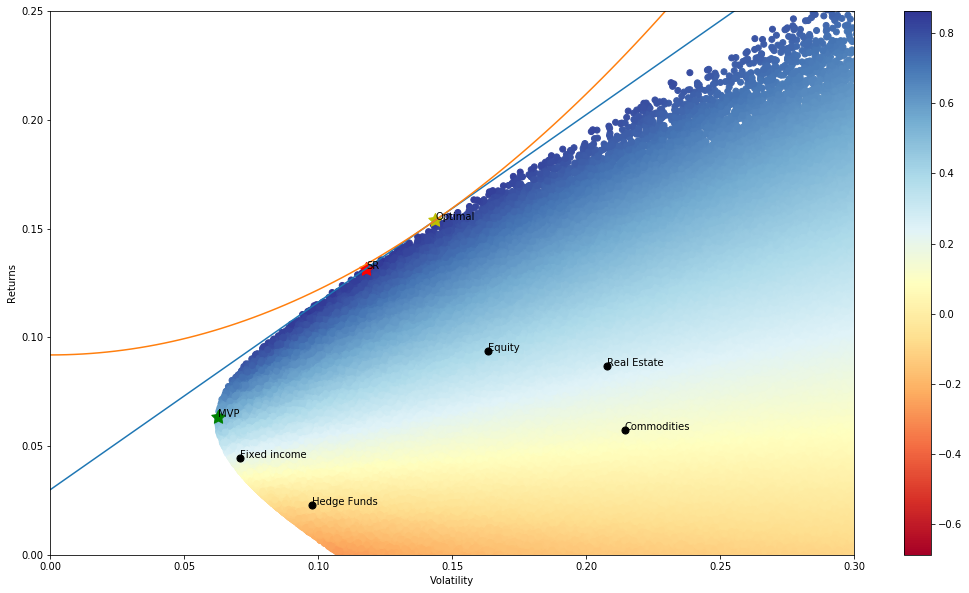

In [48]:
# An example for the code for this graph is present bellow

<br>

Secondly, with restrictions:

In [18]:
# Run the function with the E(r), std, and gamma specific to restrictions
w_T_r, E_r_o_r , std_o_r = Optimal_ret_and_std_per_gamma(E_r_T_r, std_T_r, gamma)

# Add the results to the compare_table
question_3['o_r_6'] = [E_r_o_r, std_o_r]

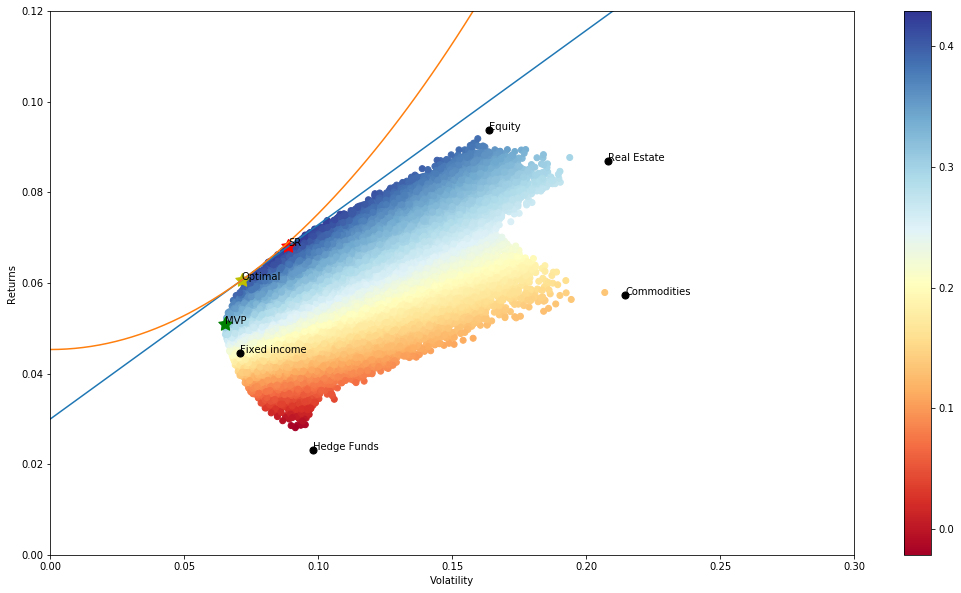

In [19]:
def graph_formulas(formula, x_range):  
    x = np.array(x_range)  
    y = formula(x)
    plt.plot(x, y)  

# Set configuration of the graph
plt.figure(figsize=(18, 10))
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.ylim((0.00,0.12))
plt.xlim((0.00,0.3))

# Create scatter plot coloured by Sharpe Ratio
plt.scatter(results_table_r.stdev,results_table_r.ret,c=results_table_r.sharpe,cmap='RdYlBu')    
plt.colorbar()

# Add classes
plt.scatter(sample_indicators['std'], sample_indicators['mean'], marker="o",color='xkcd:black',s=50)
for i, txt in enumerate(data.columns.tolist()):
    plt.annotate(txt, (sample_indicators['std'].tolist()[i],sample_indicators['mean'].tolist()[i]))

# Plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_r[1],min_vol_r[0],marker=(5,1,0),color='g',s=200)
plt.annotate('MVP', (min_vol_r[1],min_vol_r[0]))    
    
# Plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_r[1],max_sharpe_r[0],marker=(5,1,0),color='r',s=200)
plt.annotate('SR', (max_sharpe_r[1],max_sharpe_r[0]))
             
# Add CML line
graph_formulas(lambda x: (r_f + (max_sharpe_r[0]-r_f)*(x/max_sharpe_r[1])), np.linspace(0.0,0.3, 100))

# Add optimal portfolio 
plt.scatter(std_o_r,E_r_o_r,marker=(5,1,0),color='y',s=200)
plt.annotate('Optimal', (std_o_r,E_r_o_r))

# Add investors utility curve
graph_formulas(lambda x: ((E_r_o_r - gamma*(std_o_r**2)/2)+gamma*(x**2)/2), np.linspace(0.0,0.3, 100))

plt.show();

<br>

Comparing both restricted and not restricted:

In [20]:
question_3

,T_nr,T_r,o_nr_6,o_r_6
E(r),0.121227,0.068071,0.154104,0.060637
σ,0.105720,0.088797,0.143819,0.071457


<br>

Compare different levels of aversion:


In [21]:
# Define different gammas
different_gammas = [2, 4, 8, 10]

In [22]:
# Create a loop that recalculates the returns and the std per value of gamma
for item in different_gammas:
    # Recalculate return and std for 'not restricted' and 'restricted'
    w_T_nr_item, E_r_o_nr_item , std_o_nr_item = Optimal_ret_and_std_per_gamma(E_r_T_nr, std_T_nr, item)
    w_T_r_item, E_r_o_r_item , std_o_r_item = Optimal_ret_and_std_per_gamma(E_r_T_r, std_T_r, item)    
    
    # Add the new value to the comparison table
    question_3['o_nr_'+str(item)] = [E_r_o_nr_item, std_o_nr_item]
    question_3['o_r_'+str(item)] = [E_r_o_r_item, std_o_r_item]

In [23]:
# Show the comparison table with the new results varying with gamma
question_3

,T_nr,T_r,o_nr_6,o_r_6,o_nr_2,o_r_2,o_nr_4,o_r_4,o_nr_8,o_r_8,o_nr_10,o_r_10
E(r),0.121227,0.068071,0.154104,0.060637,0.402311,0.121910,0.216156,0.075955,0.123078,0.052977,0.104462,0.048382
σ,0.105720,0.088797,0.143819,0.071457,0.431458,0.214371,0.215729,0.107185,0.107864,0.053593,0.086292,0.042874


In [24]:
# Show the comparison table with the new results varying with gamma for not restricted
question_3_o_nr = question_3[['o_nr_2', 'o_nr_4', 'o_nr_6', 'o_nr_8', 'o_nr_10']]
question_3_o_nr

,o_nr_2,o_nr_4,o_nr_6,o_nr_8,o_nr_10
E(r),0.402311,0.216156,0.154104,0.123078,0.104462
σ,0.431458,0.215729,0.143819,0.107864,0.086292


In [25]:
# Show the comparison table with the new results varying with gamma for restricted
question_3_o_r = question_3[['o_r_2', 'o_r_4', 'o_r_6', 'o_r_8', 'o_r_10']]
question_3_o_r

,o_r_2,o_r_4,o_r_6,o_r_8,o_r_10
E(r),0.121910,0.075955,0.060637,0.052977,0.048382
σ,0.214371,0.107185,0.071457,0.053593,0.042874


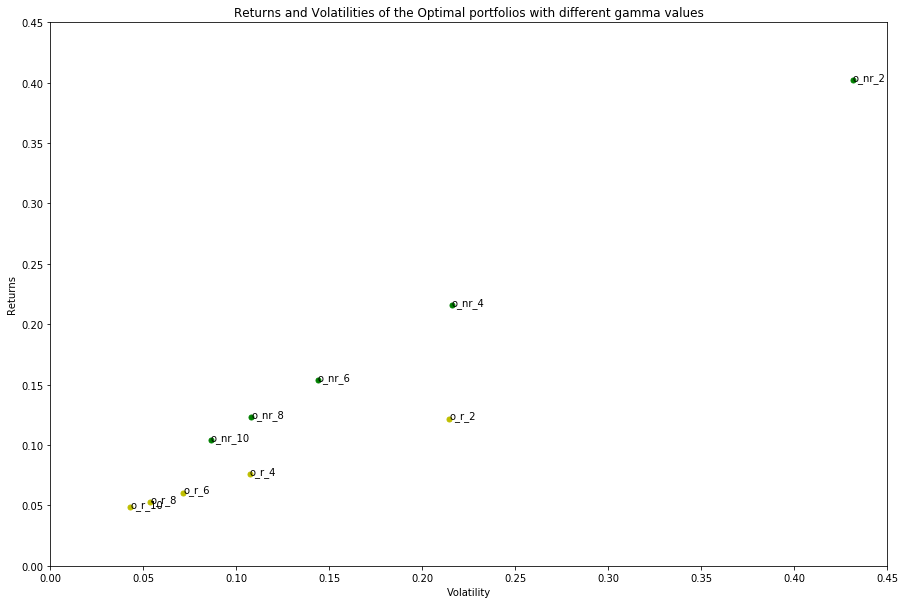

In [26]:
# Plot the Returns Volatility scatter
fig, ax = plt.subplots(figsize = (15,10))
ax.scatter(question_3_o_r.iloc[1], question_3_o_r.iloc[0], marker='o',color='y',s=25)
ax.scatter(question_3_o_nr.iloc[1], question_3_o_nr.iloc[0], marker='o',color='g',s=25)

# Add the labels to each point
for i, txt in enumerate(question_3.columns.tolist()[2:]):
    ax.annotate(txt, (question_3.iloc[1].tolist()[i+2],question_3.iloc[0].tolist()[i+2]))

# Define the limits for the graph
plt.ylim((0.00,0.45))
plt.xlim((0.00,0.45))

# Define the labels
plt.title('Returns and Volatilities of the Optimal portfolios with different gamma values')
plt.xlabel('Volatility')
plt.ylabel('Returns');

________

## Question 4

__  What is the impact on your prior recommendations if the expected return changes? Perform a sensitivity analysis and comment on the differences. __

In [27]:
# Specify different expected return changes
better_returns = 1.20
worse_returns = 0.80

In [28]:
# Update the expected returns with the two options
sample_indicators['mean_better'] = sample_indicators['mean']*better_returns
sample_indicators['mean_worse'] = sample_indicators['mean']*worse_returns

# Show the new table
sample_indicators

,max,mean,min,std,mean_better,mean_worse
Commodities,0.143364,0.057365,-0.182563,0.214668,0.068838,0.045892
Equity,0.109478,0.093698,-0.179928,0.163640,0.112437,0.074958
Fixed income,0.059763,0.044597,-0.033792,0.070766,0.053516,0.035678
Hedge Funds,0.042825,0.023104,-0.051908,0.097868,0.027725,0.018483
Real Estate,0.174583,0.086825,-0.143572,0.208031,0.104190,0.069460


________

## Question 5

__  Finally, Mrs. Crusoe asks you to suggest 3 stocks and to estimate expected returns and standard deviation (total, systematic and idiosyncratic) on each of them according to the CAPM. Would you recommend the investment in any of the 3 stocks? Explain. __

In [71]:
# Define access to Quandl
quandl.ApiConfig.api_key = API_key

# Get S&P500 tickers
sp500_symbols = list(pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",
                            header=0)[0].loc[:, "Ticker symbol"])

# Get Quandl available tickers
quandl_symbols = quandl.get_table('WIKI/PRICES', qopts = {'columns': 'ticker'},
                                  date = {'gte': '2017-11-06', 'lte': '2017-11-07' }).ticker.unique()

In [73]:
# Define the sp500 table
sp500 = pd.DataFrame()

# Define the function that gets the weekly returns for a specific ticker
def ticker_getter(tick):
    if tick in quandl_symbols:
        sp500[tick] = quandl.get("WIKI/"+tick, start_date="2005-01-07", end_date="2017-11-29",
                                 collapse="weekly", column_index = [11])['Adj. Close']
        print(tick, 'is done.')

# Run the function for all the tickers in the S&P500
[ticker_getter(i) for i in sp500_symbols];

MMM is done.
ABT is done.
ABBV is done.
ACN is done.
ATVI is done.
AYI is done.


KeyboardInterrupt: 

In [ ]:
# Remove entries with no values
sp500 = sp500.dropna(axis=1, how='any')

# Display the clean table
sp500.head()